<a href="https://www.kaggle.com/code/khaleedismail/carvana-segmentation-task-nn?scriptVersionId=289298121" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/carvana-image-masking-png/train_images/f8b6f4c39204_12.jpg
/kaggle/input/carvana-image-masking-png/train_images/c4ac16c0dd59_10.jpg
/kaggle/input/carvana-image-masking-png/train_images/c3614abc7405_08.jpg
/kaggle/input/carvana-image-masking-png/train_images/f3b482e091c0_15.jpg
/kaggle/input/carvana-image-masking-png/train_images/bb7625a3f1d4_16.jpg
/kaggle/input/carvana-image-masking-png/train_images/28109f18d9d4_11.jpg
/kaggle/input/carvana-image-masking-png/train_images/cafee4122080_12.jpg
/kaggle/input/carvana-image-masking-png/train_images/fa613ac8eac5_13.jpg
/kaggle/input/carvana-image-masking-png/train_images/768f299c36e1_08.jpg
/kaggle/input/carvana-image-masking-png/train_images/d9b2ded58b72_16.jpg
/kaggle/input/carvana-image-masking-png/train_images/f1eb080c7182_11.jpg
/kaggle/input/carvana-image-masking-png/train_images/02159e548029_15.jpg
/kaggle/input/carvana-image-masking-png/train_images/c52b272a5329_08.jpg
/kaggle/input/carvana-image-masking-png/train_image

In [2]:
from fastai.vision.all import *

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
path = Path('/kaggle/input/carvana-image-masking-png')

In [4]:
image_path = path/'train_images'
mask_path = path/'train_masks'

In [5]:
def get_items(path):
    return get_image_files(image_path)

def get_mask_fn(path_item):
    return mask_path / f'{Path(path_item).stem}.png'

In [6]:
codes = ['background', 'car']

In [7]:
def get_dls(bs, size):
    return DataBlock(blocks=(ImageBlock, MaskBlock(codes = codes)),
                    get_items = get_items,
                    get_y=get_mask_fn,
                    splitter=RandomSplitter(valid_pct=0.2, seed=42),
                    item_tfms=Resize(size),
                    batch_tfms=[
                        Normalize.from_stats(*imagenet_stats)
                    ]).dataloaders(path, bs=bs)

In [8]:
dls = get_dls(16, 256)

In [9]:
xb, yb = first(dls.valid)
if len(yb.shape) == 3:
    yb = yb.unsqueeze(1)  # [batch, 1, H, W]
xb.shape, yb.shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 1, 256, 256]))

In [10]:
def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )
    return conv

In [11]:
def trans(in_c, out_c):
    return nn.ConvTranspose2d(
        in_channels = in_c,
        out_channels = out_c,
        kernel_size=2, 
        stride = 2
    )

In [12]:
def crop_img(source_tensor, target_tensor):
    """
    Resize source_tensor to match target_tensor's spatial dimensions
    """
    import torch.nn.functional as F
    
    target_h, target_w = target_tensor.shape[2:]
    return F.interpolate(source_tensor, size=(target_h, target_w), 
                         mode='bilinear', align_corners=True)


In [13]:
class UNet(Module):
    def __init__(self):
        super(UNet, self ).__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(3, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)

        self.bottle_neck = double_conv(1024, 2048)

        self.trans = trans(2048, 1024)
        self.up_conv = double_conv(2048, 1024)

        self.trans_1 = trans(1024, 512)
        self.up_conv_1 = double_conv(1024, 512)

        self.trans_2 = trans(512, 256)
        self.up_conv_2 = double_conv(512, 256)

        self.trans_3 = trans(256, 128)
        self.up_conv_3 = double_conv(256, 128)

        self.trans_4 = trans(128, 64)
        self.up_conv_4 = double_conv(128, 64)

        self.out = nn.Conv2d(
            in_channels = 64,
            out_channels = 1,
            kernel_size = 1
        )
    def forward(self, dls):
        input_size = dls.shape[2:]

        #encoder
        x1 = self.down_conv_1(dls)#
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)#
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)#
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)#
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)#
        x10 = self.max_pool_2x2(x9)

        #bottleneck
        b = self.bottle_neck(x10)
        
        #decoder
        x = self.trans(b)
        y = crop_img(x9, x)
        x = self.up_conv(torch.cat([x, y], 1))

        x = self.trans_1(x9)
        y = crop_img(x7, x)
        x = self.up_conv_1(torch.cat([x, y], 1))

        x = self.trans_2(x)
        y = crop_img(x5, x)
        x = self.up_conv_2(torch.cat([x, y], 1))

        x = self.trans_3(x)
        y = crop_img(x3, x)
        x = self.up_conv_3(torch.cat([x, y], 1))

        x = self.trans_4(x)
        y = crop_img(x1, x)
        x = self.up_conv_4(torch.cat([x, y], 1))

        x = self.out(x)
        x = x.squeeze(1)

        if x.shape[1:] != input_size:
            print(f"Warning: Output {x.shape[1:]} doesn't match input {input_size}")
            x = F.interpolate(x.unsqueeze(1), size=input_size, 
                              mode='bilinear', align_corners=True).squeeze(1)
        return x

In [14]:
model = UNet()

In [15]:
class DiceBCELoss(nn.Module):
    def __init__(self, dice_weight=0.7, bce_weight=0.3, smooth=1e-6):
        super().__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.smooth = smooth
        
    def forward(self, pred, target):
        """
        Args:
            pred: (B, 1, H, W) or (B, H, W) - logits
            target: (B, 1, H, W) or (B, H, W) - should be float [0, 1]
        """
        # ========== CRITICAL FIX ==========
        # Convert target to float if it's long (common with PyTorch masks)
        if target.dtype == torch.long:
            target = target.float()
        
        # If target values are 0-255 (common with PNG masks), normalize to 0-1
        if target.max() > 1.0:
            target = target / 255.0
        
        # Ensure pred is float too
        pred = pred.float()
        
        # Handle different dimensions
        if pred.dim() == 3:  # [B, H, W]
            pred = pred.unsqueeze(1)  # [B, 1, H, W]
        if target.dim() == 3:  # [B, H, W]
            target = target.unsqueeze(1)  # [B, 1, H, W]
        # ==================================
        
        # BCE loss
        bce = F.binary_cross_entropy_with_logits(pred, target)
        
        # Dice loss
        pred_sigmoid = torch.sigmoid(pred)
        
        # Flatten
        pred_flat = pred_sigmoid.view(-1)
        target_flat = target.view(-1)
        
        intersection = (pred_flat * target_flat).sum()
        dice_score = (2. * intersection + self.smooth) / (pred_flat.sum() + target_flat.sum() + self.smooth)
        dice_loss = 1 - dice_score
        
        return self.bce_weight * bce + self.dice_weight * dice_loss

In [16]:
class BinaryDice(Metric):
    def __init__(self, threshold=0.5):
        self.threshold = threshold
        self.reset()
        
    def reset(self):
        self.intersection = 0
        self.union = 0
        self.total = 0
        
    def accumulate(self, learn):  # ← CHANGE: Take 'learn' parameter
        pred = learn.pred  # Get prediction from learner
        target = learn.yb[0]  # Get target from learner
        
        # Convert target to float if needed
        if target.dtype == torch.long:
            target = target.float()
        
        # Normalize if needed (0-255 to 0-1)
        if target.max() > 1.0:
            target = target / 255.0
        
        # Get probabilities from logits
        pred_probs = torch.sigmoid(pred)
        
        # Convert to binary
        pred_binary = (pred_probs > self.threshold).float()
        
        # Ensure same shape
        if target.dim() == 3:
            target = target.unsqueeze(1)
        if pred_binary.dim() == 3:
            pred_binary = pred_binary.unsqueeze(1)
        
        # Flatten
        pred_flat = pred_binary.view(-1)
        target_flat = target.view(-1)
        
        intersection = (pred_flat * target_flat).sum()
        union = pred_flat.sum() + target_flat.sum()
        
        self.intersection += intersection.item()
        self.union += union.item()
        self.total += 1
        
    @property
    def value(self):
        if self.union == 0:
            return 0.0
        return (2. * self.intersection) / self.union
    
    @property
    def name(self):
        return "dice"

SuggestedLRs(valley=9.120108734350652e-05)

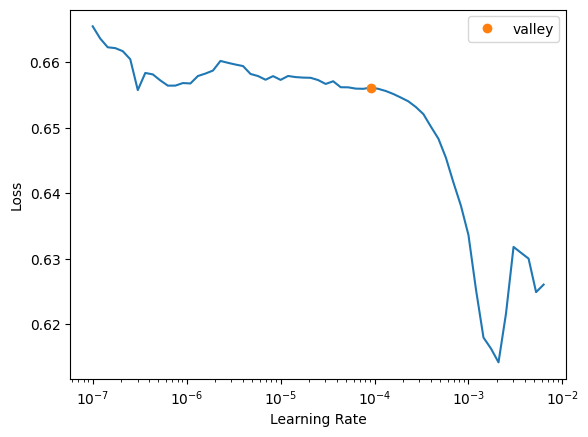

In [17]:
learn = Learner(dls, model, metrics=BinaryDice,opt_func=Adam,
               loss_func=DiceBCELoss(dice_weight=0.7, bce_weight=0.3))
learn.lr_find()

In [18]:
learn.fit(10, 3e-3)

epoch,train_loss,valid_loss,dice,time
0,0.950163,0.645896,0.000000,03:32
1,0.655682,0.646200,0.000000,03:31
2,0.652702,0.646069,0.000000,03:27
3,0.653042,0.646113,0.000000,03:29
4,0.654115,0.646299,0.000000,03:29
5,0.653855,0.646249,0.000000,03:29
6,0.652892,0.646068,0.000000,03:32
7,0.653234,0.646138,0.000000,03:30
8,0.653039,0.646137,0.000000,03:30
9,0.655314,0.646444,0.000000,03:32


In [19]:
learn.save('carvana_epoch_1.pkl')

Path('models/carvana_epoch_1.pkl.pth')

In [20]:
learn = learn.load('carvana_epoch_1.pkl')
learn.unfreeze()
learn.fit(10, 3e-3)

epoch,train_loss,valid_loss,dice,time
0,0.653436,0.646177,0.000000,03:30
1,0.653973,0.646272,0.000000,03:29
2,0.653067,0.646138,0.000000,03:31
3,0.653930,0.646334,0.000000,03:31
4,0.653723,0.646186,0.000000,03:32
5,0.653021,0.646132,0.000000,03:32
6,0.654585,0.646337,0.000000,03:30
7,0.653457,0.646183,0.000000,03:32
8,0.653576,0.646177,0.000000,03:32
9,0.653029,0.646047,0.000000,03:31


In [21]:
learn.export('carvana.pkl')
learn = load_learner('carvana.pkl')

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [22]:
import urllib.request
from pathlib import Path
from PIL import Image
from fastai.vision.all import *
import torch

img_url = 'https://tse2.mm.bing.net/th/id/OIP.Ic4l2PgAA9QE0OAdKzvtjQHaEw?w=800&h=514&rs=1&pid=ImgDetMain&o=7&rm=3'

# Download the image
filename = 'test_car.jpg'
urllib.request.urlretrieve(img_url, filename)

# Load original
original_img = PILImage.create(filename)
print(f"Original size: {original_img.size}")

# Check what size your model expects
# If you used Resize(256) in training, model expects 256x256
# If you don't know, check your dataloaders:
print(f"Model input size: {dls.one_batch()[0].shape}")  # [B, C, H, W]

# Resize to match model input (e.g., 256x256)
target_size = 256  # Or whatever your model was trained on
resized_img = original_img.resize((target_size, target_size))
resized_img.save('test_car_resized.jpg')

# Load resized image for prediction
img_path = PILImage.create('test_car_resized.jpg')
print(f"Resized to: {img_path.size}")

Original size: (800, 514)
Model input size: torch.Size([16, 3, 256, 256])
Resized to: (256, 256)


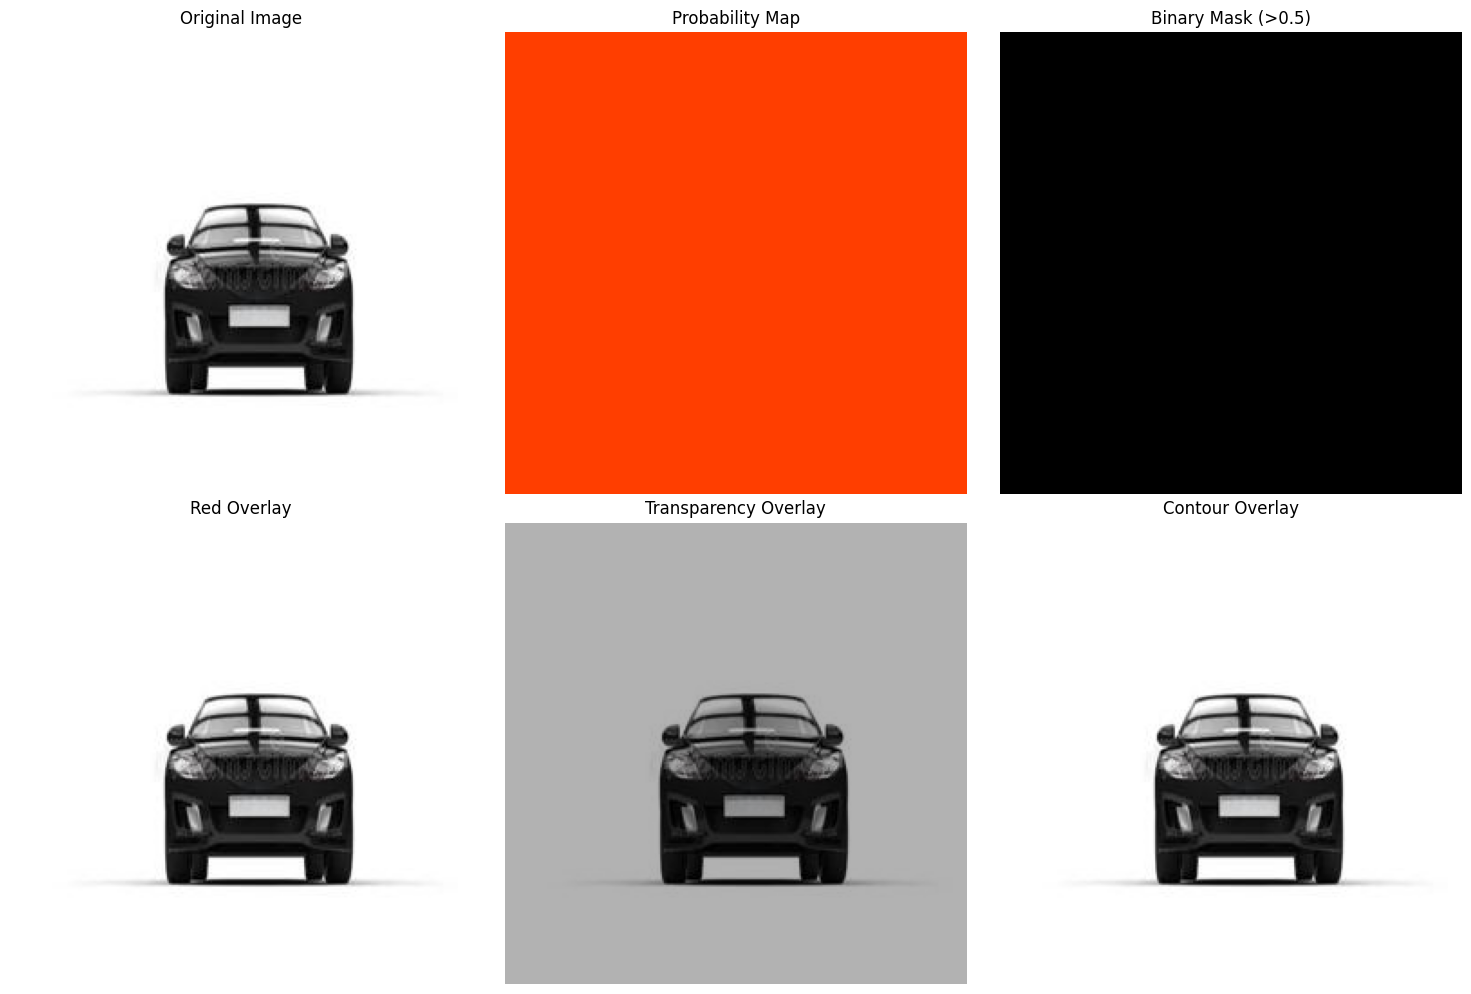

Car pixels: 0
Car coverage: 0.0%


In [23]:
def predict_and_visualize(learn, img_path, threshold=0.5, save_path=None):
    """
    Predict mask and visualize results
    """
    # Load image
    img = PILImage.create(img_path)
    
    # Predict
    pred_mask, _, _ = learn.predict(img)
    
    # Get logits
    if hasattr(pred_mask, 'data'):
        logits = pred_mask.data
    else:
        logits = pred_mask
    
    # Convert to probabilities and binary mask
    probs = torch.sigmoid(logits)
    binary_mask = (probs > threshold).float()
    
    # Convert to numpy
    img_np = np.array(img)
    mask_np = binary_mask.squeeze().cpu().numpy()
    prob_np = probs.squeeze().cpu().numpy()
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Row 1
    axes[0, 0].imshow(img_np)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(prob_np, cmap='hot', vmin=0, vmax=1)
    axes[0, 1].set_title(f'Probability Map')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(mask_np, cmap='gray')
    axes[0, 2].set_title(f'Binary Mask (>{threshold})')
    axes[0, 2].axis('off')
    
    # Row 2: Overlays
    # Red overlay
    red_overlay = img_np.copy()
    red_overlay[mask_np == 1] = [255, 0, 0]  # Set mask pixels to red
    axes[1, 0].imshow(red_overlay)
    axes[1, 0].set_title('Red Overlay')
    axes[1, 0].axis('off')
    
    # Transparency overlay
    overlay = img_np * 0.7 + np.stack([mask_np*255]*3, axis=-1) * 0.3
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)
    axes[1, 1].imshow(overlay)
    axes[1, 1].set_title('Transparency Overlay')
    axes[1, 1].axis('off')
    
    # Contour
    axes[1, 2].imshow(img_np)
    from skimage import measure
    contours = measure.find_contours(mask_np, 0.5)
    for contour in contours:
        axes[1, 2].plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
    axes[1, 2].set_title('Contour Overlay')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    
    plt.show()
    
    # Return results
    return {
        'image': img_np,
        'logits': logits,
        'probabilities': prob_np,
        'binary_mask': mask_np,
        'height': mask_np.shape[0],
        'width': mask_np.shape[1],
        'car_pixels': int(mask_np.sum()),
        'car_percentage': float(mask_np.sum() / mask_np.size * 100)
    }

# Usage
result = predict_and_visualize(learn, img_path, threshold=0.5)
print(f"Car pixels: {result['car_pixels']:,}")
print(f"Car coverage: {result['car_percentage']:.1f}%")